In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.simplefilter(action="ignore", category=FutureWarning)
sns.set_theme(color_codes=True, style="whitegrid")

# Učitavanje podataka

Skidanje cijena pomoću yfinance paketa:

In [3]:
tickers = ["SPY", "AGG", "GC=F", "VNQ"]

prices = yf.download(tickers, start="2012-01-01", end="2023-12-31")["Adj Close"]

prices

[*********************100%***********************]  4 of 4 completed


Ticker,AGG,GC=F,SPY,VNQ
Date,,,,
2012-01-03 00:00:00+00:00,78.706375,1599.699951,101.091934,35.285412
2012-01-04 00:00:00+00:00,78.599068,1611.900024,101.250511,34.682137
2012-01-05 00:00:00+00:00,78.706375,1619.400024,101.520111,35.007896
2012-01-06 00:00:00+00:00,78.770752,1616.099976,101.258461,34.893272
2012-01-09 00:00:00+00:00,78.706375,1607.500000,101.504265,34.772633
...,...,...,...,...
2023-12-22 00:00:00+00:00,95.252731,2057.100098,469.225250,85.181526
2023-12-26 00:00:00+00:00,95.445503,2058.199951,471.206573,85.812798
2023-12-27 00:00:00+00:00,96.052696,2081.899902,472.058533,86.230392


Učitavanje CSV datoteke koja sadrži podatke o težinama različitih klasa imovine kroz godine (2012-2024)

In [4]:
csvfile = pd.read_csv("asset_class_marketcaps.csv", skiprows=1)
marketcap_years = [str(year) for year in range(2012, 2024)]
weights_years = [str(year) + ".1" for year in range(2012, 2024)]

marketcap_df = csvfile[["Asset class"] + marketcap_years]

weights_df = csvfile[["Asset class"] + weights_years]
weights_df.columns = ["Asset class"] + marketcap_years

weights_df = weights_df.set_index("Asset class")

weights_df = weights_df.apply(lambda x: x.str.rstrip("%").astype(float) / 100)

weights_df.style.format("{:,.2%}")

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Asset class,,,,,,,,,,,,
Equity,35.06%,40.81%,40.62%,40.64%,40.67%,42.67%,40.41%,42.43%,42.44%,46.09%,45.04%,46.72%
Fixed income,48.21%,46.00%,46.19%,46.63%,46.53%,44.80%,46.90%,44.99%,45.52%,42.45%,42.95%,41.62%
Commodity,12.27%,8.30%,7.74%,7.10%,7.33%,7.15%,7.29%,7.33%,7.93%,6.92%,8.04%,7.93%
Real estate,4.47%,4.89%,5.46%,5.63%,5.46%,5.38%,5.41%,5.25%,4.12%,4.54%,3.97%,3.73%


Pretvaranje cijena tickera u postotne povrate (razlika u cijeni iz dana u dan)

In [5]:
change = prices.pct_change(1, fill_method=None).dropna()
change

Ticker,AGG,GC=F,SPY,VNQ
Date,,,,
2012-01-04 00:00:00+00:00,-0.001363,0.007626,0.001569,-0.017097
2012-01-05 00:00:00+00:00,0.001365,0.004653,0.002663,0.009393
2012-01-06 00:00:00+00:00,0.000818,-0.002038,-0.002577,-0.003274
2012-01-09 00:00:00+00:00,-0.000817,-0.005321,0.002427,-0.003457
2012-01-10 00:00:00+00:00,-0.000273,0.014619,0.008671,0.011103
...,...,...,...,...
2023-12-22 00:00:00+00:00,-0.001314,0.008827,0.002010,0.003891
2023-12-26 00:00:00+00:00,0.002024,0.000535,0.004223,0.007411
2023-12-27 00:00:00+00:00,0.006362,0.011515,0.001808,0.004866


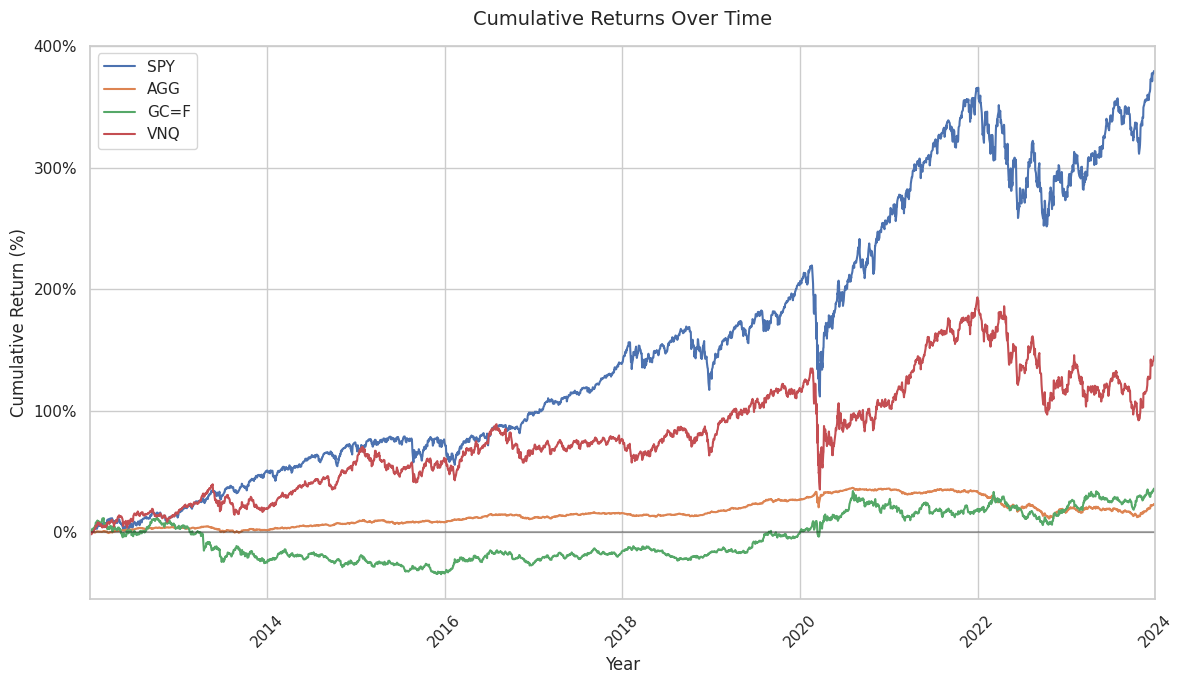

In [6]:
cumulative_returns = (1 + change).cumprod() - 1

plt.figure(figsize=(12, 7))

for ticker in tickers:
    plt.plot(
        cumulative_returns.index,
        cumulative_returns[ticker] * 100,
        label=ticker,
        linewidth=1.5,
    )

plt.axhline(y=0, color="black", linestyle="-", alpha=0.3)

plt.title("Cumulative Returns Over Time", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cumulative Return (%)", fontsize=12)

plt.xlim(cumulative_returns.index.min(), pd.Timestamp("2024-01-01"))


plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0f}%".format(y)))

plt.xticks(rotation=45)

plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

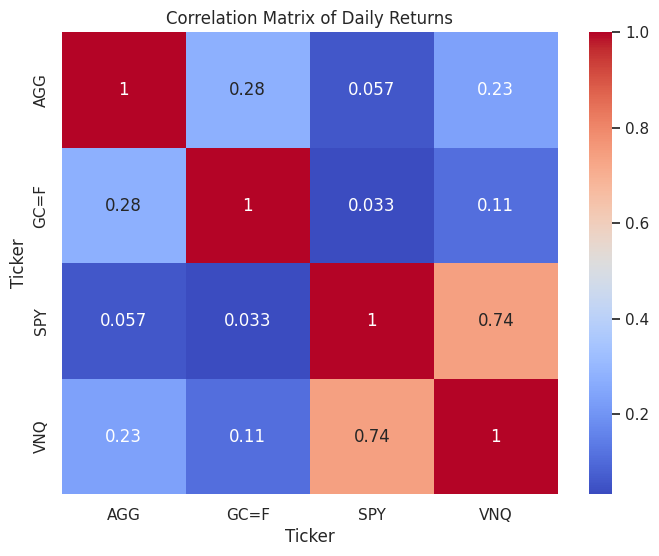

In [7]:
corr = change.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Daily Returns")
plt.show()

Pretvaranje dnevnih povrata u godišnje povrate radi konteksta

In [8]:
yearly_change = change.groupby(change.index.year).apply(lambda x: (1 + x).prod() - 1)
yearly_change.index.name = "Year"

yearly_change.style.format("{:,.2%}")

Ticker,AGG,GC=F,SPY,VNQ
Year,,,,
2012,3.96%,4.69%,14.17%,16.65%
2013,-1.98%,-28.24%,32.31%,2.30%
2014,6.00%,-1.50%,13.46%,30.40%
2015,0.48%,-10.44%,1.23%,2.43%
2016,3.22%,12.03%,13.01%,5.80%
2017,3.55%,13.59%,21.71%,4.90%
2018,0.68%,-0.96%,-2.94%,-4.05%
2019,8.46%,18.87%,31.22%,28.91%
2020,7.48%,24.59%,18.33%,-4.61%


# Mapiranje i izračun ponderiranih prinosa

Mapiranje indeksa za svaku klasu imovine i izračun godišnjih ponderiranih prinosa za svaku klasu koristeći prethodno definirane težine

In [9]:
asset_class_to_ticker_map = {
    "Equity": "SPY",
    "Fixed income": "AGG",
    "Commodity": "GC=F",
    "Real estate": "VNQ",
}

weights_df_copy = weights_df.copy()

weights_df_copy.rename(index=asset_class_to_ticker_map, inplace=True)
weights_df_copy = weights_df_copy.transpose()
weights_df_copy.index = weights_df_copy.index.astype("int64")

weighted_returns = weights_df_copy.multiply(yearly_change)

weighted_returns.style.format("{:,.2%}")

,AGG,GC=F,SPY,VNQ
2012,1.91%,0.58%,4.97%,0.74%
2013,-0.91%,-2.34%,13.18%,0.11%
2014,2.77%,-0.12%,5.47%,1.66%
2015,0.22%,-0.74%,0.50%,0.14%
2016,1.50%,0.88%,5.29%,0.32%
2017,1.59%,0.97%,9.26%,0.26%
2018,0.32%,-0.07%,-1.19%,-0.22%
2019,3.80%,1.38%,13.25%,1.52%
2020,3.40%,1.95%,7.78%,-0.19%
2021,-0.75%,-0.24%,13.24%,1.84%


Izračun ukupnog prinosa indeksa po godinama zbrajanjem ponderiranih prinosa svih klasa imovine.

In [10]:
index_returns = weighted_returns.sum(axis=1).to_frame()

index_returns.index.name = "Year"
index_returns.columns = ["Index Returns"]

index_returns.style.format("{:,.2%}")

,Index Returns
Year,
2012,8.20%
2013,10.04%
2014,9.78%
2015,0.12%
2016,7.99%
2017,12.09%
2018,-1.16%
2019,19.95%
2020,12.94%


# Izračun dnevnih povrata

Priprema dnevnih težina indeksa i spajanje s Fama-French faktorima za izračun dnevnih prekomjernih prinosa (excess returns) indeksa i pojedinačnih klasa imovine

*NAPOMENA:* uzima se pretpostavka da su težine klasa imovine konstantne kroz godinu i primijenjene su na svaki dan radi izračuna dnevnih povrata indeksa

In [11]:
daily_weights_df = change.index.to_frame()

daily_weights_df["Year"] = daily_weights_df["Date"].dt.year
daily_weights_df = daily_weights_df.merge(
    weights_df_copy, left_on="Year", right_index=True
).set_index("Date")

daily_weights_df = daily_weights_df.drop(columns="Year")

daily_index_change = change.multiply(daily_weights_df).sum(axis=1)

In [12]:
kenneth_french_df = pd.read_csv("F-F_Research_Data_Factors_daily.CSV", skiprows=4)
kenneth_french_df = kenneth_french_df[:-3]

kenneth_french_df["Date"] = pd.to_datetime(kenneth_french_df["Date"], format="%Y%m%d")
kenneth_french_df = kenneth_french_df.set_index("Date")

kenneth_french_df

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009
...,...,...,...,...
2024-09-20,-0.27,-0.72,-0.64,0.020
2024-09-23,0.21,-0.85,-0.08,0.020
2024-09-24,0.24,0.12,-0.58,0.020


In [13]:
change.index = change.index.tz_localize(None)
daily_index_change.index = daily_index_change.index.tz_localize(None)

start_date = change.index[0]
end_date = change.index[-1]

filtered_kenneth_french_df = kenneth_french_df.loc[start_date:end_date]["RF"][1:] / 100
filtered_kenneth_french_df = filtered_kenneth_french_df.reindex(
    change.index, fill_value=0
)

In [14]:
excess_index = daily_index_change.add(-filtered_kenneth_french_df, axis="index")
excess_change = change.add(-filtered_kenneth_french_df, axis="index")

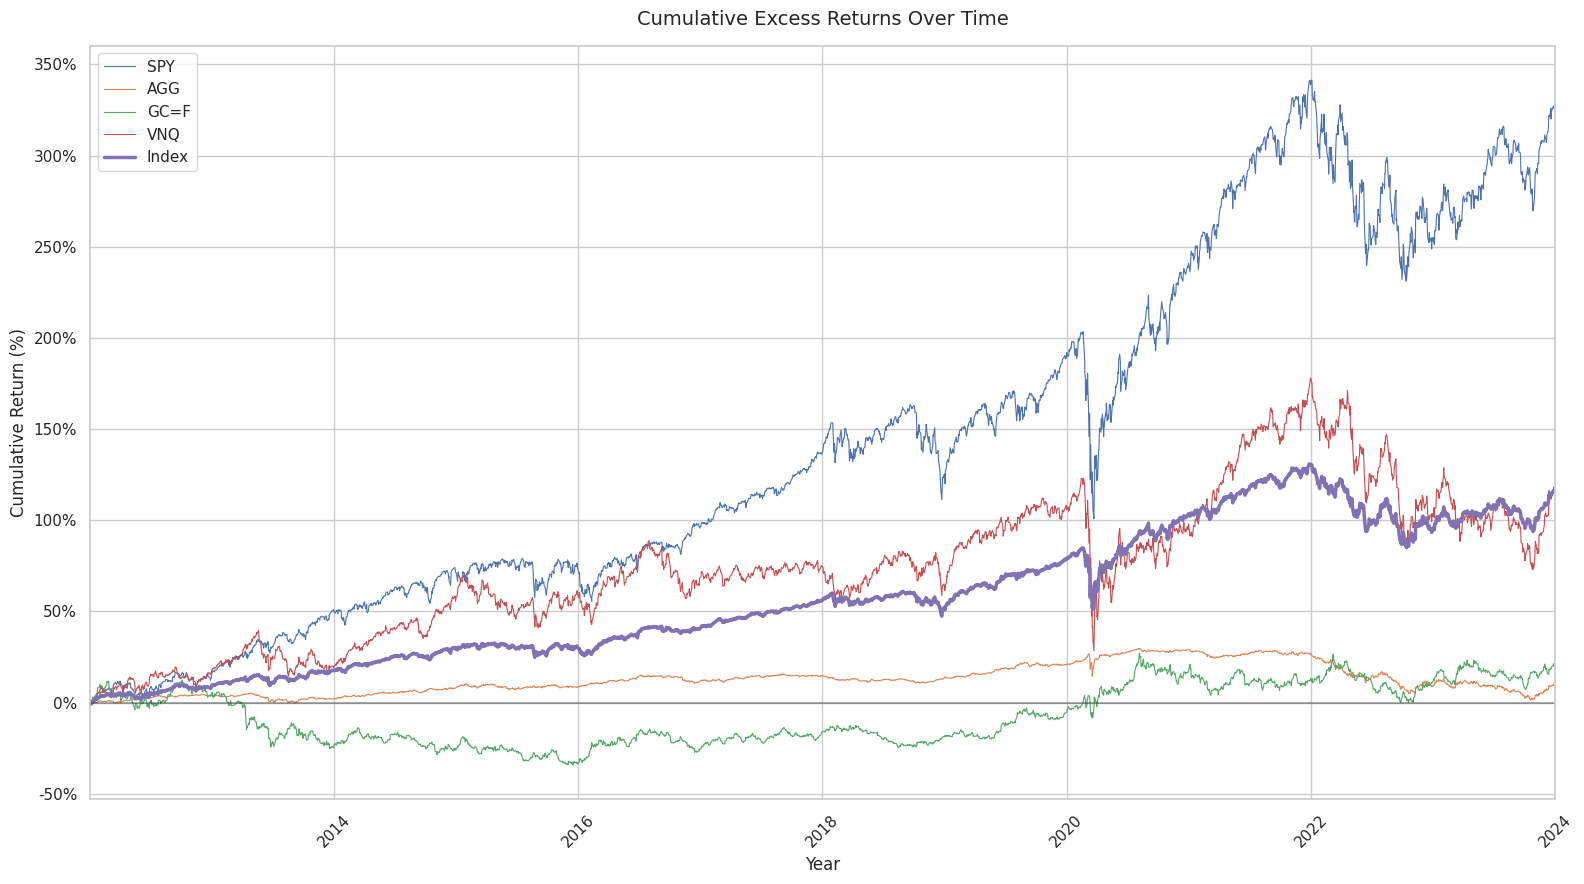

In [25]:
cumulative_returns_excess_change = (1 + excess_change).cumprod() - 1
cumulative_returns_excess_index = (1 + excess_index).cumprod() - 1


plt.figure(figsize=(16, 9))

for ticker in tickers:
    plt.plot(
        cumulative_returns_excess_change.index,
        cumulative_returns_excess_change[ticker] * 100,
        label=ticker,
        linewidth=0.8,
    )

plt.plot(
    cumulative_returns_excess_index.index,
    cumulative_returns_excess_index * 100,
    label="Index",
    linewidth=2.5,
)

plt.axhline(y=0, color="black", linestyle="-", alpha=0.3)

plt.title("Cumulative Excess Returns Over Time", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cumulative Return (%)", fontsize=12)

plt.xlim(cumulative_returns.index.min(), pd.Timestamp("2024-01-01"))


plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0f}%".format(y)))

plt.xticks(rotation=45)

plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

# CAPM linearna regresija

Ovaj dio koda implementira linearnu regresiju za Capital Asset Pricing Model (CAPM) koristeći metodu običnih najmanjih kvadrata (OLS). CAPM model je dan jednadžbom:

$R_i - R_f = \alpha_i + \beta_i(R_m - R_f) + \epsilon_i$

gdje je:
- $R_i - R_f$ excess return imovine indeksa i
- $R_m - R_f$ excess return indeksa/tržišta (market risk premium)
- $\alpha_i$ (alfa) mjeri performansu imovine iznad/ispod očekivanja tržišta
- $\beta_i$ (beta) mjeri osjetljivost na tržišne promjene
- $\epsilon_i$ je slučajna pogreška (pretpostavljen na 0)

Beta koeficijent se računa kao:

$\beta = \frac{\sum(x - \bar{x})(y - \bar{y})}{\sum(x - \bar{x})^2}$ to jest
$\beta = \frac{\mathrm{Cov}(R_{\mathrm{stock}}, R_{\mathrm{market}})}{\mathrm{Var}(R_{\mathrm{market}})}$

gdje su $x$ i $y$ prekomjerni prinosi tržišta i imovine.

Koeficijent determinacije ($R^2$) računa se kao:

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

gdje je $SS_{res}$ suma kvadrata reziduala, a $SS_{tot}$ ukupna suma kvadrata.

$R^2$ pokazuje koliki dio varijance u prinosima pojedine imovine možemo objasniti kretanjem tržišta. Na primjer, $R^2$ od 0.75 znači da 75% promjena u prinosima imovine možemo pripisati tržišnim kretanjima, dok preostalih 25% dolazi od drugih faktora specifičnih za tu imovinu.

Sjena oko regresijske linije predstavlja 95% interval pouzdanosti unutar kojeg linija stvarno leži.

In [16]:
def linear_regression(stock_returns=excess_change, index_returns=excess_index):
    """
    Implement linear regression for CAPM from scratch using ordinary least squares (OLS).

    """

    result = pd.DataFrame(columns=["Ticker", "Alpha", "Beta", "R_squared"])

    n = len(excess_change)

    x_mean = excess_index.mean()

    for stock in stock_returns.columns:
        selected_stock = stock_returns[stock]
        y_mean = selected_stock.mean()

        xy_sum = sum((index_returns - x_mean) * (selected_stock - y_mean))

        x_square_sum = sum((index_returns - x_mean) ** 2)

        beta = xy_sum / x_square_sum
        alpha = y_mean - beta * x_mean

        # R-squared
        y_pred = alpha + beta * index_returns
        ss_res = selected_stock.sub(y_pred).pow(2).sum()  # residual sum of squares
        ss_tot = selected_stock.sub(y_mean).pow(2).sum()  # total sum of squares
        r_squared = 1 - (ss_res / ss_tot)

        row = pd.DataFrame(
            {
                "Ticker": [stock],
                "Alpha": [alpha],
                "Beta": [beta],
                "R_squared": [r_squared],
            }
        )
        result = pd.concat([result, row], ignore_index=True)

    result.set_index("Ticker", inplace=True)

    return result


result = linear_regression()
result

,Alpha,Beta,R_squared
Ticker,,,
AGG,-0.000022,0.210800,0.137069
GC=F,-0.000017,0.467242,0.065283
SPY,0.000041,1.843455,0.871428
VNQ,-0.000167,1.855787,0.642027


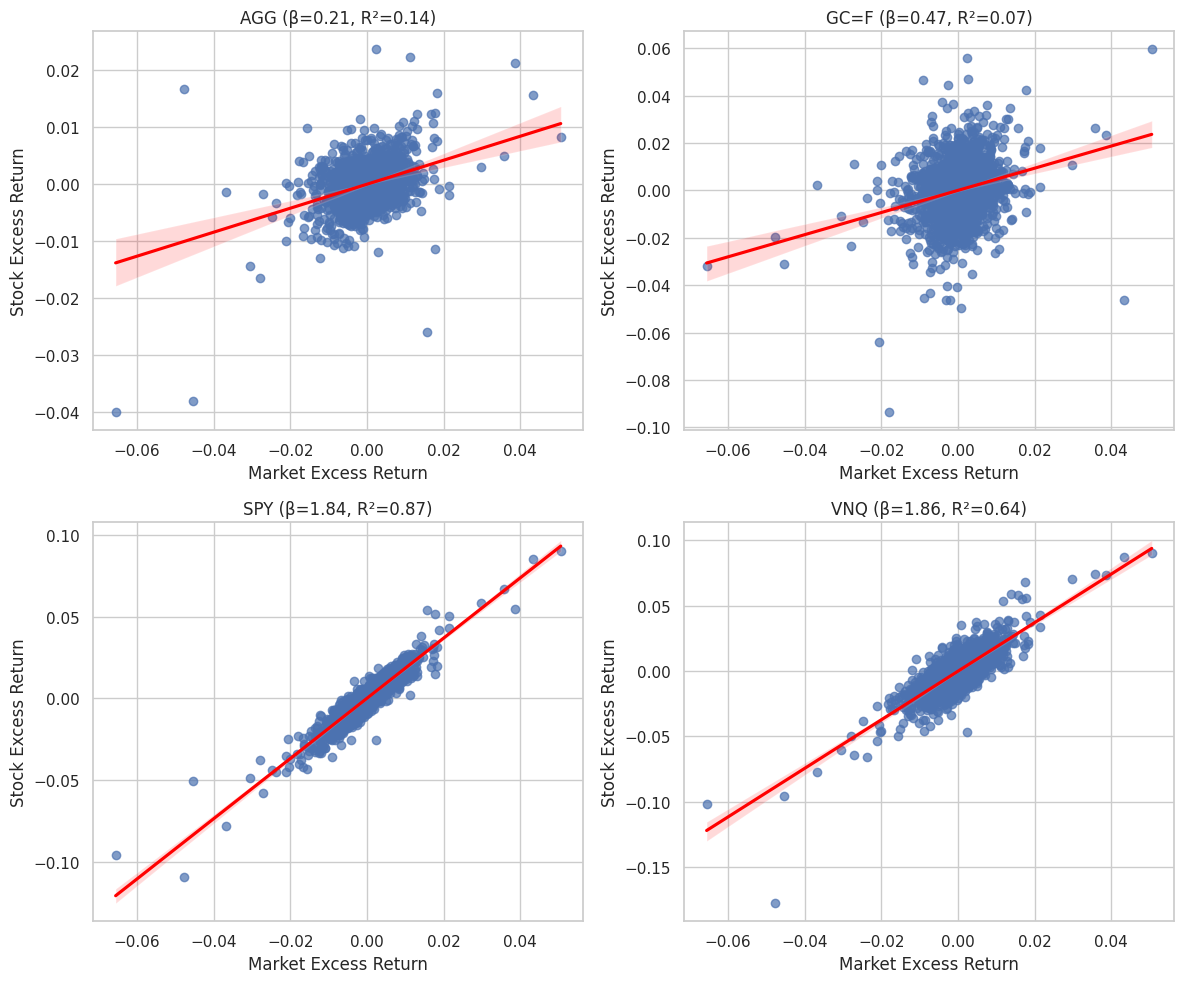

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, stock in enumerate(excess_change.columns):

    y = excess_change[stock]

    beta = result.loc[stock, "Beta"]
    alpha = result.loc[stock, "Alpha"]

    sns.regplot(
        x=excess_index,
        y=y,
        ax=axes[idx],
        scatter_kws={"alpha": 0.7},  # Transparency for points
        line_kws={"color": "red"},  # Regression line color
    )

    # axes[idx].scatter(excess_index, y, alpha=0.9)
    # y_pred = alpha + beta * excess_index
    # axes[idx].plot(excess_index, y_pred, 'r-')

    axes[idx].set_title(
        f'{stock} (β={beta:.2f}, R²={result.loc[stock, "R_squared"]:.2f})'
    )
    axes[idx].set_xlabel("Market Excess Return")
    axes[idx].set_ylabel("Stock Excess Return")

plt.tight_layout()
plt.show()

In [18]:
start_year = excess_change.index[0].year
end_year = excess_change.index[-1].year + 1

yearly_excess_returns = excess_change.groupby(excess_change.index.year).apply(
    lambda x: (1 + x).prod() - 1
)
yearly_excess_returns.index.name = "Year"

# Predviđanje prinosa koristeći ekvilibrijski model i CAPM

## Ekvilibrijski model

Funkcija računa očekivane prinose aktive koristeći dvije ključne komponente:

1. Kovarijantnu matricu excess returns
2. Koeficijent averzije prema riziku (λ)

Očekivani povrati se računaju prema formuli:

$$
\mu = \lambda \Sigma w_{\text{mkt}}
$$

gdje je:

- $\mu$ vektor očekivanih prinosa imovine
- $\Sigma$ kovarijantna matrica (anualizirana)
- $w$ vektor tržišnih (ravnotežnih) težina portfelja
- $\lambda$ koeficijent averzije prema riziku, može biti fiksan (2.5) ili se estimira kao omjer implicirane tržišne premije rizika i varijance tržišta:

  $$
  \lambda = \frac{\mu_{\text{mkt}} - r_f}{\delta_{\text{mkt}}^2}
  $$



Rezultati se uspoređuju sa stvarnim vrijednostima na prozorima veličine `window` s obzirom na `lam_param` $\epsilon$ [False, True]

*NAPOMENE:*
- Za svaki period, težine klasa imovine $w_{\text{mkt}}$ koje se uzimaju za izračun su težine klasa imovine na kraju svakog perioda
- Primjer: za period 2012-2014 (godine 2012, 2013, 2014), $w_{\text{mkt}}$ = [40.62, 46.19, 7.74, 5.46] što predstavlja težine klasa imovine 2014.
- Sve metrike su anualizirane, kao i predviđeni prinosi

In [41]:
def switch(window, lam_param):

    comparison = pd.DataFrame(
        columns=["Period", "Ticker", "Predicted", "Real", "Window", "Lambda"]
    )

    for period in range(start_year, end_year, window):
        start_date = f"{period}-01-01"
        end_date = f"{period + window}-01-01"

        window_returns = excess_change.loc[start_date:end_date]
        window_index_return = excess_index.loc[start_date:end_date]

        cov_matrix = window_returns.cov() * 252

        realized_premium = window_index_return.mean() * 252
        market_variance = window_index_return.var() * 252

        if lam_param:
            lam = realized_premium / market_variance

        else:
            lam = 2.5

        try:
            mu = lam * cov_matrix @ weights_df_copy.loc[period + window - 1]
        except KeyError:
            continue

        for ticker in tickers:
            try:
                real_value = yearly_excess_returns.loc[period + window, ticker]
            except KeyError:
                real_value = pd.NA

            row = pd.DataFrame.from_dict(
                {
                    "Period": [f"{period} - {period + window - 1}"],
                    "Ticker": [ticker],
                    "Predicted": [mu[ticker]],
                    "Real": [real_value],
                    "Window": [window],
                    "Lambda": [f"{lam:.2f}" if lam_param else f"Fixed ({lam})"],
                }
            )

            comparison = pd.concat([comparison, row], ignore_index=True)

    return comparison


melted = switch(3, True).melt(
    id_vars=['Period', 'Ticker', 'Window', 'Lambda'],
    value_vars=["Predicted", "Real"],
    var_name="Type",
    value_name="Value"
)  # primjer DataFrame-a za dinamičnu lambdu

pivot = melted.pivot_table(
        index=['Period', 'Lambda'],
        columns=['Ticker', 'Type'],
        values='Value'
    )

pivot.style.format("{:,.2%}")

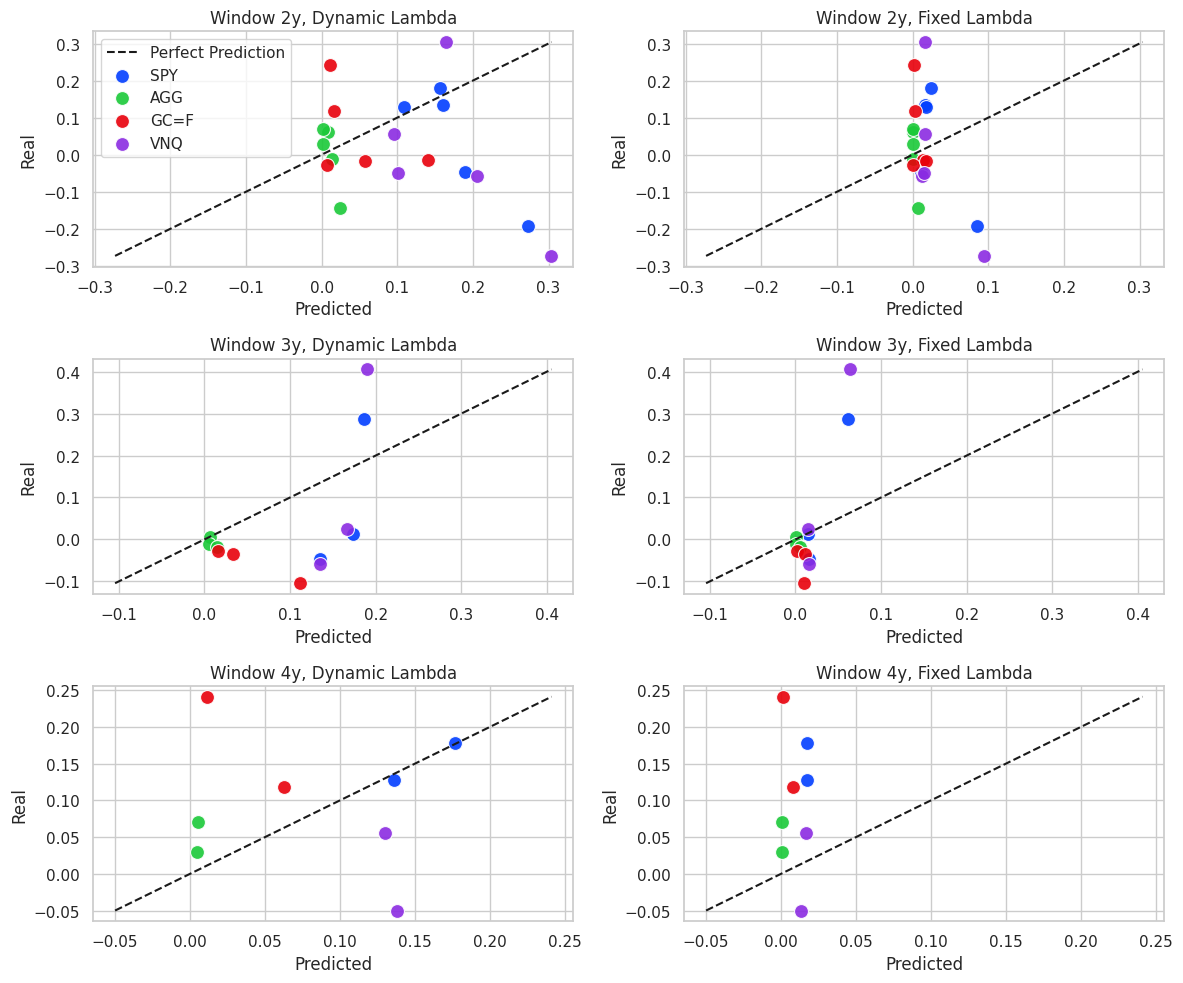

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()
index = 0

colors = sns.color_palette("bright6", n_colors=len(tickers))

for i in range(2, 5):
    for j in [True, False]:
        result = switch(i, j)
        comparison_clean = result.dropna(subset=["Real", "Predicted"])
        ax = axes[index]

        ax_min = min(
            comparison_clean["Predicted"].min(), comparison_clean["Real"].min()
        )
        ax_max = max(
            comparison_clean["Predicted"].max(), comparison_clean["Real"].max()
        )
        ax.plot([ax_min, ax_max], [ax_min, ax_max], "k--", label="Perfect Prediction")

        for idx, ticker in enumerate(tickers):
            data = comparison_clean[comparison_clean["Ticker"] == ticker]
            sns.scatterplot(
                data=data,
                x="Predicted",
                y="Real",
                label=ticker,
                color=colors[idx],
                alpha=0.9,
                s=100,
                ax=ax,
                legend=False,
            )

        ax.set_xlabel("Predicted")
        ax.set_ylabel("Real")
        title_lambda = "Dynamic" if j else "Fixed"
        ax.set_title(f"Window {i}y, {title_lambda} Lambda")

        if index == 0:
            ax.legend()

        ax.grid(True)
        index += 1

plt.tight_layout()
plt.show()

### CAPM model

Alternativni pristup predviđanju prinosa koji koristi CAPM model i beta koeficijent. Za svaki prozor `window` veličine:
1. Računa se beta linearnom regresijom za dani period
2. Očekivani prinos se računa prema formuli:

$E(R_i) = \beta_i \cdot E(R_m)$

gdje je $E(R_m)$ anualizirani očekivani tržišni prinos, a $\beta_i$ beta koeficijent za pojedinu imovinu.

*NAPOMENA:*
- Prinosi koji se koriste u formulama su prekomjerni (excess returns) tj. bezrizična stopa je već oduzeta

In [44]:
def switch2(window):

    comparison2 = pd.DataFrame(
        columns=["Period", "Ticker", "Predicted", "Real", "Window", "Beta"]
    )

    for period in range(start_year, end_year, window):
        start_date = f"{period}-01-01"
        end_date = f"{period + window}-01-01"

        window_returns = excess_change.loc[start_date:end_date]
        window_index_return = excess_index.loc[start_date:end_date]

        b = linear_regression(
            stock_returns=window_returns, index_returns=window_index_return
        )

        for ticker in tickers:
            beta = b.loc[ticker, "Beta"]
            mu = beta * window_index_return.mean() * 252

            try:
                real_value = yearly_excess_returns.loc[period + window, ticker]
            except KeyError:
                real_value = pd.NA

            row = pd.DataFrame.from_dict(
                {
                    "Period": [f"{period} - {period + window - 1}"],
                    "Ticker": [ticker],
                    "Predicted": [mu],
                    "Real": [real_value],
                    "Window": [window],
                    "Beta": [f"{beta:.2f}"],
                }
            )

            comparison2 = pd.concat([comparison2, row], ignore_index=True)

    return comparison2


melted = switch2(3).melt(
    id_vars=['Period', 'Ticker', 'Window'],
    value_vars=["Predicted", "Real"],
    var_name="Type",
    value_name="Value"
)  # primjer DataFrame-a za prozor od 3 godine

pivot = melted.pivot_table(
        index=['Period'],
        columns=['Ticker', 'Type'],
        values='Value'
    )

pivot.style.format("{:,.2%}")

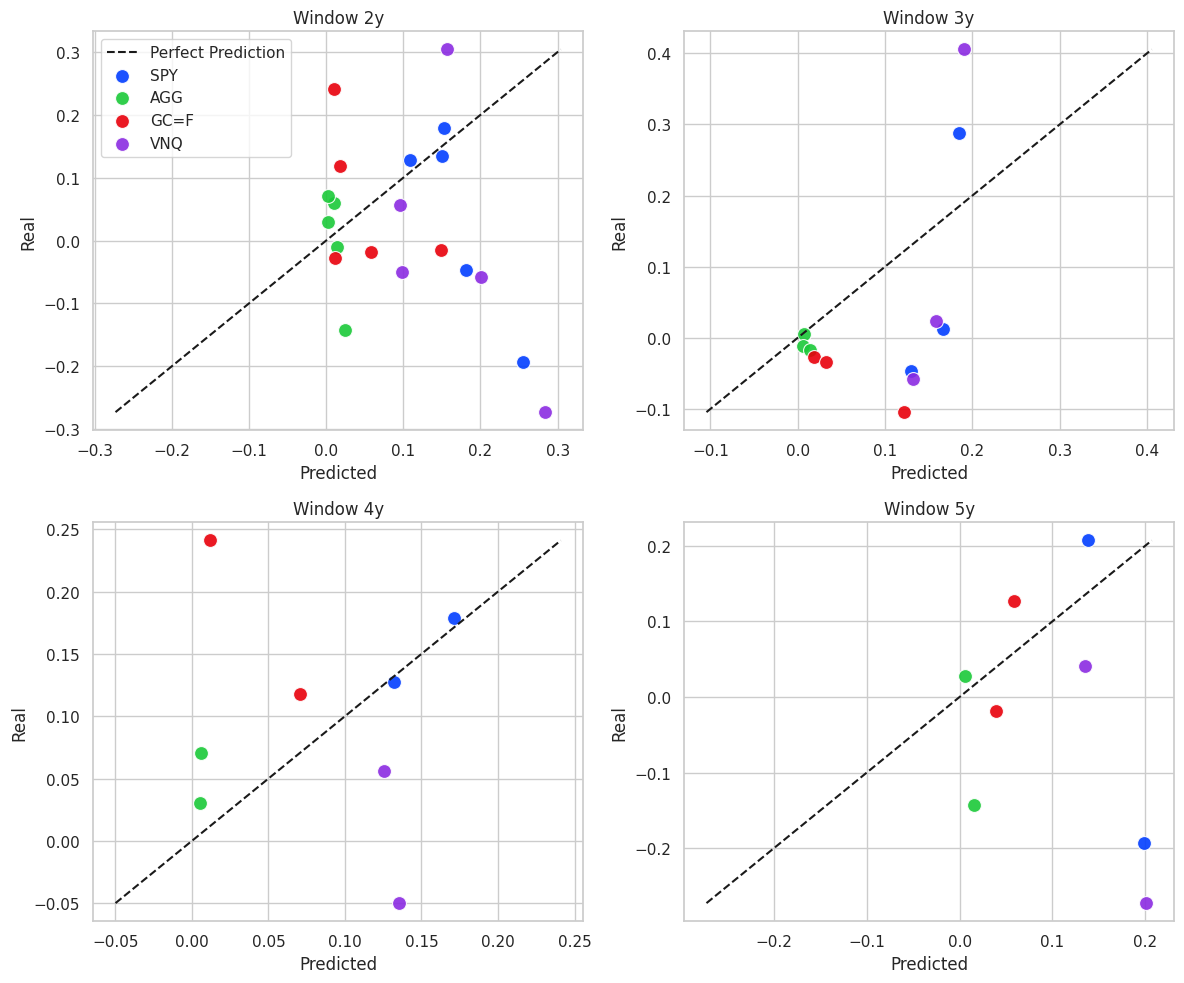

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
index = 0

for i in range(2, 6):
    result = switch2(i)
    comparison_clean = result.dropna(subset=["Real", "Predicted"])
    ax = axes[index]

    ax_min = min(comparison_clean["Predicted"].min(), comparison_clean["Real"].min())
    ax_max = max(comparison_clean["Predicted"].max(), comparison_clean["Real"].max())
    ax.plot([ax_min, ax_max], [ax_min, ax_max], "k--", label="Perfect Prediction")

    for idx, ticker in enumerate(tickers):
        data = comparison_clean[comparison_clean["Ticker"] == ticker]
        sns.scatterplot(
            data=data,
            x="Predicted",
            y="Real",
            label=ticker,
            color=colors[idx],
            alpha=0.9,
            s=100,
            ax=ax,
            legend=False,
        )

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    ax.set_title(f"Window {i}y")

    if index == 0:
        ax.legend()

    ax.grid(True)
    index += 1

plt.tight_layout()
plt.show()